In [1]:
import torch
from torch import nn,utils
from torchvision import datasets,transforms
from matplotlib import pyplot as plt
import os
%matplotlib inline

## Dataset loading

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(300),
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(300),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../Assignment5/Data set'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=13,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

avDev = torch.device("cuda:0")

## Encoder Model

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1), # batch X 16 X 256 X 256
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16,32,3,padding=1), # batch X 32 X 256 X 256
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,32,3,padding=1), # batch X 32 X 256 X 256
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,padding=1), # batch X 64 X 128 X 128
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,64,3,padding=1), # batch X 64 X 128 X 128
            nn.ReLU(),
            nn.BatchNorm2d(64), 
            nn.MaxPool2d(2,2)            # batch X 64 X 64 X 64
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,128,3,padding=1), # batch X 128 X 64 X 64
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,128,3,padding=1), # batch X 128 X 64 X 64
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128,256,3,padding=1), # batch X 256 X 32 X 32
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2,2),              # batch X 256 X 16 X 16
            nn.Conv2d(256,256,3,padding=1), # batch X 256 X 16 X 16
            nn.ReLU(),
        )
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size,-1)
        return out
        
encoder = Encoder().cuda()

## Decoder Model

In [4]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(256,256,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256,128,3,2,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128,128,3,2,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128,64,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(64,64,3,2,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64,32,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32,32,3,2,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32,16,3,1,1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16,3,3,1,1),
            nn.ReLU()
        )
    def forward(self,x):
        x = x.view(batch_size,256,16,16)
        out = self.layer1(x)
        out = self.layer2(out)
        return out
decoder = Decoder().cuda()

In [5]:
epoch = 20
batch_size = 13
lr = 0.0005

### Checking size

In [6]:
# for image,label in dataloaders['train']:
#     optimizer.zero_grad()
#     image = image
#     output = encoder(image)
#     output = decoder(output)
#     loss = loss_fn(output,image)
#     image = image.cpu()
#     loss.backward()
#     optimizer.step()
#     print(loss.item())
# print('epoch [{}/{}], loss:{:.4f}'
#           .format(i + 1, epoch, loss.item()))

In [7]:
params = list(encoder.parameters()) + list(decoder.parameters())
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params,lr)

## Training

In [8]:
if not os.path.exists('./model5'):
    os.mkdir('./model5')
try:
    encoder, decoder = torch.load('./model5/deno_autoencoder.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

for i in range(epoch):
    for image,label in dataloaders['train']:
        image_n = torch.mul(image+0.25, 0.1 * torch.rand(image.size()))
        image_n = image_n.cuda()
        #label = label.float().cuda()
        optimizer.zero_grad()
        output = encoder(image_n)
        output = decoder(output)
        image = image.cuda()
        loss = loss_fn(output,image)
        loss.backward()
        optimizer.step()
#         print(loss.item())
    print('epoch [{}/{}], loss:{:.4f}'
          .format(i + 1, epoch, loss.item()))
        
                
torch.save([encoder,decoder],'./model5/deno_autoencoder.pkl')
print(loss)



--------model not restored--------



/home/user/aggarwal/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch [1/20], loss:0.9794


/home/user/aggarwal/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch [2/20], loss:0.9648


/home/user/aggarwal/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch [3/20], loss:1.0321


/home/user/aggarwal/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch [4/20], loss:0.8969


/home/user/aggarwal/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch [5/20], loss:0.9543


/home/user/aggarwal/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch [6/20], loss:0.9485


/home/user/aggarwal/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch [7/20], loss:1.0665


/home/user/aggarwal/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch [8/20], loss:0.9652


/home/user/aggarwal/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch [9/20], loss:1.2014


/home/user/aggarwal/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch [10/20], loss:1.1315


/home/user/aggarwal/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch [11/20], loss:0.8955


/home/user/aggarwal/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch [12/20], loss:0.9514


/home/user/aggarwal/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch [13/20], loss:0.7497


/home/user/aggarwal/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch [14/20], loss:0.8514


/home/user/aggarwal/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch [15/20], loss:1.1434


/home/user/aggarwal/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch [16/20], loss:0.9451


/home/user/aggarwal/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch [17/20], loss:1.0026


/home/user/aggarwal/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch [18/20], loss:1.1720


/home/user/aggarwal/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch [19/20], loss:0.9224


/home/user/aggarwal/anaconda3/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch [20/20], loss:1.0062
tensor(1.0062, device='cuda:0', grad_fn=<MseLossBackward>)


/home/user/aggarwal/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/user/aggarwal/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/user/aggarwal/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/user/aggarwal/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "ty

In [9]:
# image_n = torch.mul(image.cpu()+0.25,0.1* torch.rand(batch_size,3,32,32))
# output = encoder(image_n.cuda())
# output = decoder(output)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


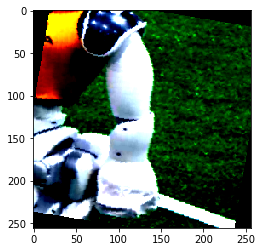

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


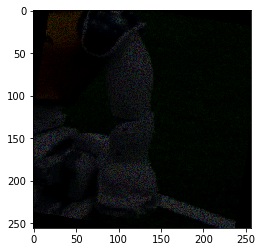

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


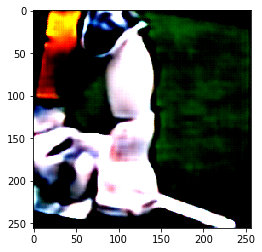

tensor(0)


In [14]:
img = image[11].cpu()
input_img = image_n[11].cpu()
output_img = output[11].detach().cpu()

plt.imshow(img.permute(1, 2, 0))
plt.show()

plt.imshow(input_img.permute(1, 2, 0))
plt.show()

plt.imshow(output_img.permute(1, 2, 0))
plt.show()

print(label[11])